# Mini project VFE
#### by Pragnya Dharmigari & Supavitch Nakburee

In [1]:
import pandas as pd
import numpy as np
import datetime
from numpy import *

# timestamp
from datetime import datetime, timedelta
from calendar import monthrange
from dateutil.relativedelta import relativedelta
import xlrd
import math

In [2]:
df = pd.read_csv("tbonds_data.csv", index_col = None, parse_dates = ['MATURITY'])

In [3]:
df.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
0,2020-09-15,1.375,100.002,100.006,unch.,-0.7744
1,2020-09-30,1.375,100.020,100.024,-0.002,-0.1290
2,2020-09-30,2.000,100.032,100.036,-0.002,-0.2547
3,2020-09-30,2.750,100.042,100.046,-0.002,-0.1080
4,2020-10-15,1.625,100.042,100.046,-0.002,0.0270


# Data cleaning

In [4]:
# lower columns's name
df.columns = df.columns.str.strip().str.lower()
df.columns

Index(['maturity', 'coupon', 'bid', 'asked', 'chg', 'asked yield'], dtype='object')

In [5]:
#Get rid off duplicate rows by choosing only first bond in the same maturity pair
df1 = df.drop_duplicates(subset = ['maturity'], keep = 'first')
df1.duplicated().head()

#A case that regards to all bonds
#df1 = df #.drop_duplicates(subset = ['maturity'], keep = 'first')
#df1.duplicated().head()

0    False
1    False
4    False
5    False
8    False
dtype: bool

# Data processing

##### Determining time to maturity

##### Assigning current date as of evaluation date of the analysis. Noted that we could assign current date for automate process.

In [6]:
# TTM
#for automate current datetime use
#dt = datetime.datetime.now()
#current_date = dt.replace(hour=0, minute=0, second=0, microsecond=0)

current_date = datetime(2020,9,12)  #datetime.date(datetime.now()) #for automate use
ttm = [((maturity - current_date).days -2) for maturity in df1['maturity']]
df1['ttm_days'] = ttm

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Counting number of payments from current time to maturity & Marking previous coupon payment time as an issue date

In [7]:
# of payments
df1['future_pmt_periods'] = df1['ttm_days']/180
df1['prev_payments'] = df1['future_pmt_periods'].apply(np.ceil) * 6
prev_pmt_date_list = list(map(lambda x,y: x + relativedelta(months = -int(y)), df1['maturity'],df1['prev_payments']))
df1['prev_pmt_date'] = prev_pmt_date_list

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

##### Computing Accrue interest & dirty price

In [8]:
# Accr interest
df1['accr_int'] = [((current_date - prev_pmt_date).days * coupon /2 / 360) for prev_pmt_date,coupon in zip(df1['prev_pmt_date'],df1['coupon'])]
df1['dirty_price'] = (df1['accr_int']) + ((df1['asked'] + df1['bid'])/2)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###### Constructing a function that would change coupon payments to either middle of month or end of month

In [9]:
def last_day_of_month(date_value):
    return date_value.replace(day = monthrange(date_value.year, date_value.month)[1])

##### Constructing entire payment cashflows and payment dates

In [10]:
#Keep payment amount and coupon payment dates in a list
bond_payment = []
bond_payment_date = []
bond_dict = []
for i in range(len(df1['future_pmt_periods'])):
    #bond_agg = []
    running = df1['future_pmt_periods'].iloc[i].copy()
    coupon_pays = []
    coupon_dates = []
    if running - int(running) == 0:
        running_date = current_date
    else:
        running_date = df1['prev_pmt_date'].iloc[i]
    while running > 1:
        if running - int(running) > 0:
            coupon_pays.append(df1['coupon'].iloc[i]/2)
            running_date = running_date + relativedelta(months = 6)
            if running_date.day == 15:
                running_date = running_date
            else:
                running_date = last_day_of_month(running_date)
            coupon_dates.append(running_date)
            running = running - (running - int(running))
        else:
            coupon_pays.append(df1['coupon'].iloc[i]/2)
            running_date = running_date + relativedelta(months = 6)
            if running_date.day == 15:
                running_date = running_date
            else:
                running_date = last_day_of_month(running_date)
            coupon_dates.append(running_date)
            running = running - 1
    else:
        coupon_pays.append(df1['coupon'].iloc[i]/2 + 100)
        coupon_dates.append(df1['maturity'].iloc[i])
    bond_payment.append(coupon_pays)
    bond_payment_date.append(coupon_dates)
    bd = dict(zip(coupon_dates,coupon_pays))
    bond_dict.append(bd)


##### Constructing coupon payments matrix which has payment dates as columns

In [11]:
#Payment matrix
payment_matrix = pd.DataFrame([bond_dict[0]])
for i in range(len(bond_dict)):
    payment_matrix = pd.concat([payment_matrix,(pd.DataFrame([bond_dict[i]]))])
payment_matrix.fillna(0, inplace = True)
payment_matrix = payment_matrix.iloc[1:]
payment_matrix.drop(payment_matrix.loc[:,(payment_matrix.columns < current_date)].columns, axis=1, inplace = True)

In [12]:
payment_matrix

,2020-09-15 00:00:00,2020-09-30 00:00:00,2020-10-15 00:00:00,2020-10-31 00:00:00,2020-11-15 00:00:00,2020-11-30 00:00:00,2020-12-15 00:00:00,2020-12-31 00:00:00,2021-01-15 00:00:00,2021-01-31 00:00:00,...,2048-05-15 00:00:00,2048-08-15 00:00:00,2048-11-15 00:00:00,2049-02-15 00:00:00,2049-05-15 00:00:00,2049-08-15 00:00:00,2049-11-15 00:00:00,2050-02-15 00:00:00,2050-05-15 00:00:00,2050-08-15 00:00:00
0,100.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,100.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,0.0000,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,0.0000,0.0000,100.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,0.0000,0.0000,0.0000,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,100.8125,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100.9375,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100.8750,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,101.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100.6875,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000


##### Adjusting payment matrix for bootstraping - only slicing dimention to cover bonds which had coupon payment dates matching with other bonds' maturity date

In [13]:
# Matrix adjustment - slicing only full payment
payment_matrix_adj = payment_matrix.copy()
dirty_price_adj = []
for i in range(len(payment_matrix.columns)):
    if payment_matrix.columns[i] not in list(df1.maturity):
        payment_matrix_adj = payment_matrix_adj.iloc[:i,:i]
        dirty_price_adj = df1['dirty_price'].iloc[:i]
        break
    else:
        pass

In [14]:
payment_matrix_adj

,2020-09-15 00:00:00,2020-09-30 00:00:00,2020-10-15 00:00:00,2020-10-31 00:00:00,2020-11-15 00:00:00,2020-11-30 00:00:00,2020-12-15 00:00:00,2020-12-31 00:00:00,2021-01-15 00:00:00,2021-01-31 00:00:00,...,2028-05-15 00:00:00,2028-08-15 00:00:00,2028-11-15 00:00:00,2029-02-15 00:00:00,2029-05-15 00:00:00,2029-08-15 00:00:00,2029-11-15 00:00:00,2030-02-15 00:00:00,2030-05-15 00:00:00,2030-08-15 00:00:00
0,100.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,100.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,0.0000,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,0.0000,0.0000,100.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,0.0000,0.0000,0.0000,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,100.8125,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100.9375,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100.8750,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,101.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,100.6875,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


# Regression

##### Regression adjusted payment matrix and dirty price to compute spot rates for each payment

In [15]:
#Regression - Matrix adjustment
x = payment_matrix_adj
y = dirty_price_adj 
discount_ft = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)

fix_nan = isnan(discount_ft)
discount_ft[fix_nan] = 0

time_vector = (payment_matrix_adj.columns - current_date).days / 360
spot_rate = -np.log(discount_ft) / time_vector

##### Ploting spot rates curve

(-0.01, 0.02)

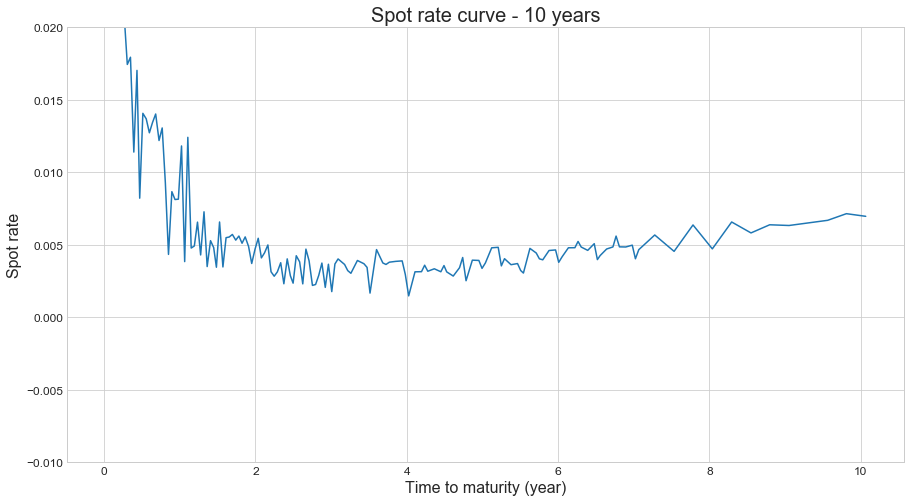

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(15, 8))
plt.plot(time_vector, spot_rate)
plt.xlabel('Time to maturity (year)', fontsize = 16)
plt.ylabel('Spot rate', fontsize = 16)
plt.title('Spot rate curve - 10 years', fontsize = 20)
plt.xticks(fontsize =12)
plt.yticks(fontsize =12)
#plt.legend(fontsize = 12)
#plt.xlim(0,10)
plt.ylim(-0.01,0.02)

# Smoothening spot curve to extrapolate spot rates up to 30 years bonds

##### Seting up various transformed variable to find the fittest distribution to spot rates

In [17]:
y = spot_rate
time_full_vector = (payment_matrix.columns - current_date).days / 360
y_log = np.nan_to_num(np.log(spot_rate))
y_exp = np.exp(spot_rate)
time_vector = time_vector
time_vector_exp = np.exp(time_vector)
time_vector_log = np.log(time_vector)
test_time = list(df1.ttm_days/360)

list_to_df = list(zip(spot_rate,time_vector,time_vector_exp,time_vector_log))
df_model_train = pd.DataFrame(list_to_df, columns = ['spot_rate','time_vector','time_vector_exp','time_vector_log'])

##### Fitting polynomial curve

In [18]:
# Trial and error with other polynomial, logarithm, and exponential.
curve_fit = np.polyfit(time_vector,y,5)
curve_fit_log = np.polyfit(time_vector,y_log,5)
curve_fit_exp = np.polyfit(time_vector,y_exp,5)

# 5 degree polynomial from logaritmic time range variables
curve_fit_log_special = np.polyfit(time_vector_log,y,6)


##### Extrapolating missing spot rates for bonds with maturity dates up to 30 years

In [19]:
t = (payment_matrix.columns - current_date).days / 360
df_prediction = pd.DataFrame()

# Trial and error with other polynomial, logarithm, and exponential.
df_prediction['spot_rate_predicted'] = (t ** 5) * curve_fit[0] + (t ** 4) * curve_fit[1] + (t ** 3) * curve_fit[2] + (t ** 2) * curve_fit[3] + (t ** 1) * curve_fit[4] + (t ** 0) * curve_fit[5]
df_prediction['spot_rate_predicted_log'] = np.exp((t ** 5) * curve_fit_log[0] + (t ** 4) * curve_fit_log[1] + (t ** 3) * curve_fit_log[2] + (t ** 2) * curve_fit_log[3] + (t ** 1) * curve_fit_log[4] + (t ** 0) * curve_fit_log[5])
df_prediction['spot_rate_predicted_exp'] = np.log((t ** 5) * curve_fit_exp[0] + (t ** 4) * curve_fit_exp[1] + (t ** 3) * curve_fit_exp[2] + (t ** 2) * curve_fit_exp[3] + (t ** 1) * curve_fit_exp[4] + (t ** 0) * curve_fit_exp[5])

# 5 degree polynomial from logaritmic time range variables
df_prediction['spot_rate_predicted_6poly_log'] =  ((((np.log(t) ** 6)) * curve_fit_log_special[0]) 
                                                + (((np.log(t)) ** 5) * curve_fit_log_special[1]) 
                                                + (((np.log(t)) ** 4) * curve_fit_log_special[2]) 
                                                + (((np.log(t)) ** 3) * curve_fit_log_special[3]) 
                                                + (((np.log(t)) ** 2) * curve_fit_log_special[4])
                                                + (((np.log(t)) ** 1) * curve_fit_log_special[5])
                                                + (((np.log(t)) ** 0) * curve_fit_log_special[6]))


out = np.zeros(len(t))
out[:len(spot_rate)] = spot_rate
spot_rate_extend = out

df_prediction['spot_rate'] = spot_rate_extend
df_prediction['time_range'] = t

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


In [25]:
# Find the SSE to benchmarking model's performance
df_prediction['discount_factor_predicted_6poly_log'] = np.exp(-df_prediction.spot_rate_predicted_6poly_log * df_prediction['time_range'])
df1['pv_bond_predicted'] = list(payment_matrix.dot(list(df_prediction['discount_factor_predicted_6poly_log'])))
ss_errors = sum((df1['dirty_price'] - df1['pv_bond_predicted']) **2 )
print("SSE from model:",round(ss_errors,2))

SSE from model: 216.14


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##### Choosing to depict the fittest spot rate curve with five degrees polynomial from logarithmic time to maturity variables

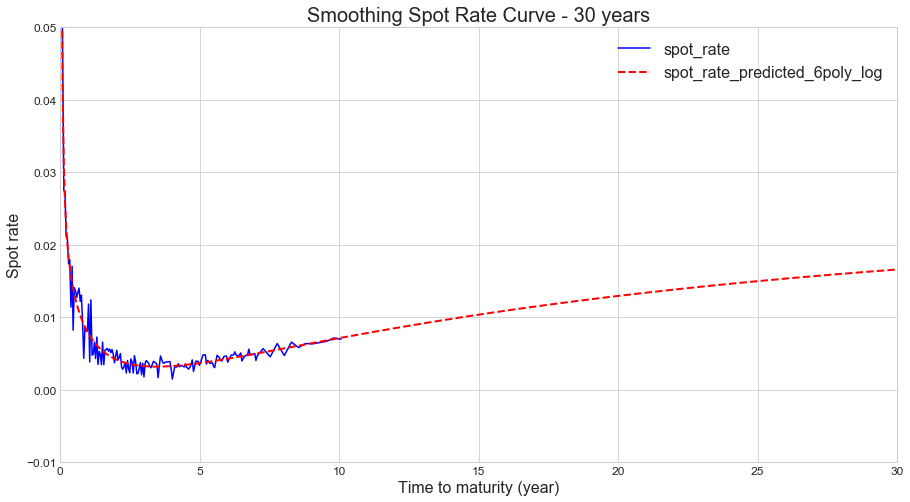

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(df_prediction['time_range'],df_prediction.spot_rate.replace(0,nan),'b',linewidth=1.5,markersize=12)
plt.plot(df_prediction['time_range'],df_prediction.spot_rate_predicted_6poly_log,'r--',linewidth=2,markersize=12)
plt.xlabel('Time to maturity (year)', fontsize = 16)
plt.ylabel('Spot rate', fontsize = 16)
plt.title('Smoothing Spot Rate Curve - 30 years', fontsize = 20)
plt.xticks(fontsize =12)
plt.yticks(fontsize =12)
plt.xlim(0,30)
plt.ylim(-0.01,0.05)
plt.legend(fontsize = 16)

# Saving payment matrix results to csv

In [22]:
#Save to CSV
payment_matrix.to_csv('payment_matrix_final.csv',index = False, header=True)
payment_matrix_adj.to_csv('payment_matrix_adj_final.csv',index = False, header=True)
df_prediction[['time_range','spot_rate','spot_rate_predicted_6poly_log']].to_csv('predicted_spot_rate.csv',index = False, header=True)